# Processing LAPD bookings received via email

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.0f}'.format

In [2]:
# read csv we've exported from postgres database with bookings
src = pd.read_csv('/Users/mhustiles/data/data/LA/latimes_bookings.csv',low_memory=False)

In [3]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
src = src.astype({'id':'object', 
            'attachment_id':'object', 
            'booking_num':'object', 
            'jail':'object', 
            'arrest_zipcode':'object'})

In [5]:
src.drop_duplicates(inplace=True)

In [6]:
bookings = pd.DataFrame(src)

In [7]:
bookings['nu_booking_date'] = bookings['booking_date']\
    .str.replace(':00-08', ':00', regex=False).str.replace(':00-07', ':00', regex=False)

bookings['nu_booking_date'] = pd.to_datetime(bookings['nu_booking_date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
bookings['nu_arrest_date'] = bookings['arrest_date']\
    .str.replace(':00-08', ':00', regex=False).str.replace(':00-07', ':00', regex=False)

bookings['nu_arrest_date'] = pd.to_datetime(bookings['nu_arrest_date'], format='%Y-%m-%d %H:%M:%S')

In [9]:
bookings['nu_release_date'] = bookings['release_date']\
    .str.replace(':00-08', ':00', regex=False).str.replace(':00-07', ':00', regex=False)

bookings['nu_release_date'] = pd.to_datetime(bookings['nu_release_date'], format='%Y-%m-%d %H:%M:%S')

In [10]:
bookings['arrest_year'] = bookings['nu_arrest_date'].dt.year
bookings['arrest_day'] = bookings['nu_arrest_date'].dt.day
bookings['arrest_month'] = bookings['nu_arrest_date'].dt.month
bookings['arrest_weekday'] = bookings['nu_arrest_date'].dt.weekday_name
bookings['arrest_monthname'] = bookings['nu_arrest_date'].dt.month_name()
bookings['arrest_hour'] = bookings['nu_arrest_date'].dt.hour.astype(object)

In [11]:
bookings.dtypes

id                             object
attachment_id                  object
booking_num                    object
booking_date                   object
jail                           object
first_name                     object
middle_name                    object
last_name                      object
suffix                         object
gender                         object
race                           object
hair_color                     object
eye_color                      object
height                        float64
weight                        float64
date_of_birth                  object
occupation                     object
arrestee_address               object
arrestee_city                  object
arrestee_state                 object
arrest_date                    object
arrest_address                 object
arrest_zipcode                 object
charge_string                  object
total_bail                    float64
no_bail                        object
release_date

---

In [12]:
bookings.arrestee_address = bookings.arrestee_address.fillna('')
bookings.booking_num = bookings.booking_num.astype(str)

In [13]:
bookings['homeless'] = bookings['arrestee_address'].str.contains('1942 TRANSIENT')

In [14]:
bookings = bookings.fillna('')

In [15]:
bookings.loc[0]

id                                             41825
attachment_id                                    156
booking_num                                  2660329
booking_date                  2011-03-02 16:20:00-08
jail                                            4279
first_name                                    DAREON
middle_name                                   JOSHUA
last_name                                   WILLIAMS
suffix                                              
gender                                             M
race                                               B
hair_color                                       BLK
eye_color                                        BRO
height                                           509
weight                                           150
date_of_birth                             1986-06-13
occupation                                  SECURITY
arrestee_address                      608 COLEMAN ST
arrestee_city                            LOS A

---

## Arrests trends for homeless and non-homeless LA residents

### Count arrests by year and type and drop 2009, 2020 and a handful of missing year rows in the dataframe

In [16]:
years = bookings.groupby(['homeless', 'arrest_year'])\
    .agg('size').reset_index(name='bookings').drop([0,1,12,13,14,15,26,27])

### What's the homeless resident arrest share — and how has that changed over time?

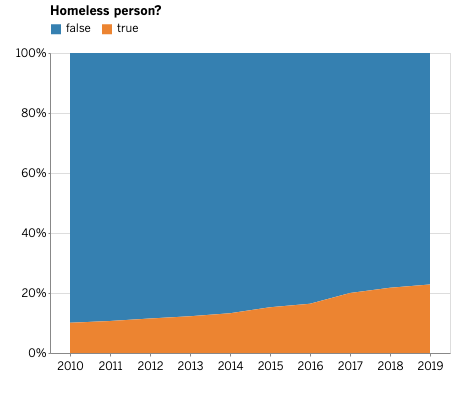

In [36]:
homeless_arrests_share = alt.Chart(years).mark_area().encode(
    y=alt.Y('bookings:Q', stack="normalize", axis=alt.Axis(format='%', tickCount=7), title=' '),
    x=alt.X('arrest_year:N', title=' '),
    color=alt.Color('homeless', title='Homeless person?')
).properties(width=400,height=300)

homeless_arrests_share.configure_legend(
    orient='top'
)

### How have LAPD's homeless arrest counts changed overtime?

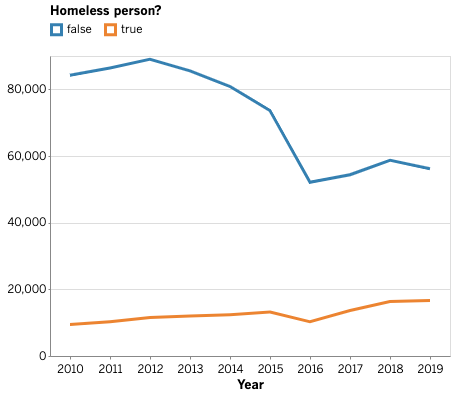

In [35]:
homeless_arrests_trend_line = alt.Chart(years).mark_line().encode(
    x=alt.X('arrest_year:N', title='Year'),
    y=alt.Y('bookings:Q', axis=alt.Axis(tickCount=6, format=''), title=' '),
    color=alt.Color('homeless', title='Homeless person?')
)

homeless_arrests_trend_line.configure_legend(
    orient='top',
).properties(width=400,height=300, title='')

In [19]:
years_pivot = pd.DataFrame(years.pivot(index='arrest_year', \
                                       columns='homeless', values='bookings').reset_index())

In [20]:
years_pivot = pd.pivot_table(years, index='arrest_year', 
                       columns=['homeless'],
                       values = 'bookings',
                       aggfunc=np.sum,
                       margins=True).reset_index()

In [21]:
years_pivot.to_csv('output/years_pivot.csv')

In [22]:
years_pivot

homeless,arrest_year,False,True,All
0,2010,84232,9433,93665
1,2011,86375,10300,96675
2,2012,88985,11532,100517
3,2013,85540,11965,97505
4,2014,80839,12369,93208
5,2015,73629,13208,86837
6,2016,52121,10262,62383
7,2017,54387,13627,68014
8,2018,58712,16337,75049
9,2019,56154,16614,72768


---

## Import Los Angeles geography

### LAPD divisions

In [23]:
divisions_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/output/lapd_divisions.json')

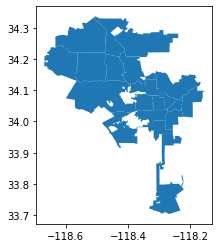

In [24]:
divisions_src.plot()

In [25]:
divisions_src.columns = divisions_src.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [26]:
divisions = divisions_src[['aprec', 'prec', 'area', 'geometry']]

### LA Times neighborhoods

In [27]:
hoodssrc = gpd.read_file('/Users/mhustiles/data/github/notebooks/lapd-crimes-arrests/input/custom-la-hoods-skid-row.geojson')

In [28]:
hoodssrc.columns = hoodssrc.columns.str.strip().str.lower().str.replace(' ', '_')\
    .str.replace('(', '').str.replace(')', '')

### Trim the neighborhoods dataframe

In [29]:
hoods = hoodssrc[['name', 'geometry']]

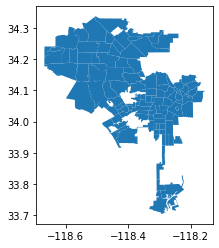

In [30]:
hoodssrc.plot()